In [10]:
DEV_PATH = '/home/frossi/dev/'
import sys
if not DEV_PATH in sys.path:
    sys.path.append(DEV_PATH)
    
from functools import partial

from zernike import *
from propagation import *

import scipy
import scipy.special

import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

sp.init_printing(use_latex='mathjax')

zf = zernikeFormulas

realZernike = zf['realZernike'].rhs
realZernikeNormalized = zf['realZernikeNormalized'].rhs
realZernikeCartesian = zf['realZernikeCartesian'].rhs
complexZernike = zf['complexZernike'].rhs
complexZernikeNormalized = zf['complexZernikeNormalized'].rhs
diffractedZernike = zf['diffractedZernike'].rhs
diffractedZernikeAtFocus = zf['diffractedZernikeAtFocus'].rhs
diffractedComplexZernikeAtFocus = zf['diffractedComplexZernikeAtFocus'].rhs


In [11]:
npoints = 256
radius = 5

def standardPsfPlot(img):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    s = img.shape[0]
    axs[0].imshow(img, cmap='jet')
    axs[1].plot(img[s//2, :])
    axs[2].plot(img[:, s//2])
    plt.show()    
    
def modesIterator(ff, max_mode=10):
    for ni in range(max_mode):
        nn,mm = noll_to_zern(ni+1)
        ff(nn,mm)
        
def createPolarSampling(rrr, npoints):
    xx, yy = np.meshgrid(np.linspace(-rrr, rrr, npoints), np.linspace(-rrr,rrr, npoints))
    rr, tt = np.sqrt(xx**2+yy**2), np.arctan2(yy, xx)
    bb = np.ones_like(rr)
#    bb[np.where(rr>rrr)] = 0 # np.nan
    return rr, tt, bb

def createCartesianSampling(rrr, npoints):
    xx, yy = np.meshgrid(np.linspace(-rrr, rrr, npoints), np.linspace(-rrr,rrr, npoints))
    bb = np.ones_like(xx)
#    bb[np.where(np.sqrt(xx**2+yy**2)>rrr)] = 0 # np.nan
    return rr, tt, bb

def createLambdaFromRealPolar(nn, mm, zf):
    r= sp.symbols('r', positive=True)
    theta= sp.symbols('theta', real=True)

    ddz = subsParamsByName(zf, {'m':mm, 'n':nn, 'rho':r})
    display(ddz)
    dz = sp.lambdify((r, theta), ddz, [{'binomial': scipy.special.binom}, 'scipy'])
    return dz

def createLambdaFromComplexPolar(nn, mm, zcf):
    r= sp.symbols('r', positive=True)
    theta= sp.symbols('theta', real=True)

    ddz = realZFromComplexZ(zcf, nn, mm).subs(rho, r)
    dz = sp.lambdify((r, theta), ddz.subs(f, np.pi), [{'binomial': scipy.special.binom}, 'scipy'])
    return dz

def samplePolarFunction(nn, mm, fz, isReal=True):
    rr, tt, bb = createPolarSampling(radius, npoints)
    dz = createLambdaFromRealPolar(nn, mm, fz) if isReal else createLambdaFromComplexPolar(nn, mm, fz)
    U = dz(rr, tt) * bb        
    return np.real(U)

def showRealComplexFunctionDiff(nn, mm, fr, fc):
    Ur1 = samplePolarFunction(nn, mm, fr, True)
    Ur2 = samplePolarFunction(nn, mm, fc, False)
    standardPsfPlot( Ur1-Ur2 )

def showFunction(nn, mm, ff, isReal=True, doLog=False):
    Ur1 = samplePolarFunction(nn, mm, ff, isReal)
#    print('sum:', np.sum(np.square(np.absolute(Ur1)))*np.pi/(npoints*npoints*np.pi/4))
    print('sum:', np.sum((np.square(np.absolute(Ur1))))*np.pi*radius*radius/(npoints*npoints*np.pi/4))
    print('max:', np.max(Ur1))
    if doLog: Ur1=np.log(np.absolute(Ur1))
    standardPsfPlot( Ur1 )
    

besselj(1, 2⋅π⋅r)
─────────────────
        r        

sum: 3.0605605142808354
max: 3.1296868161178892


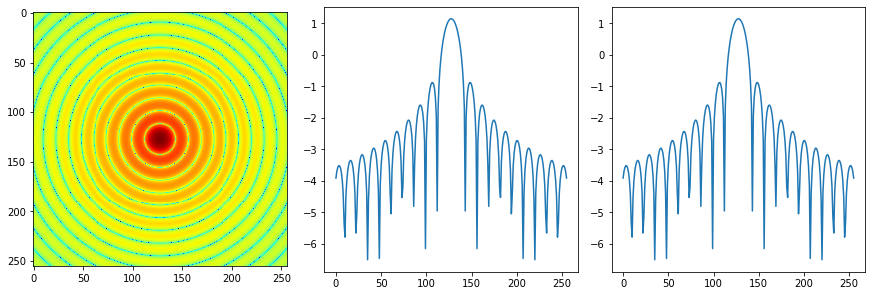

cos(θ)⋅besselj(2, 2⋅π⋅r)
────────────────────────
           r            

sum: 0.750886140467626
max: 1.1287025666743613


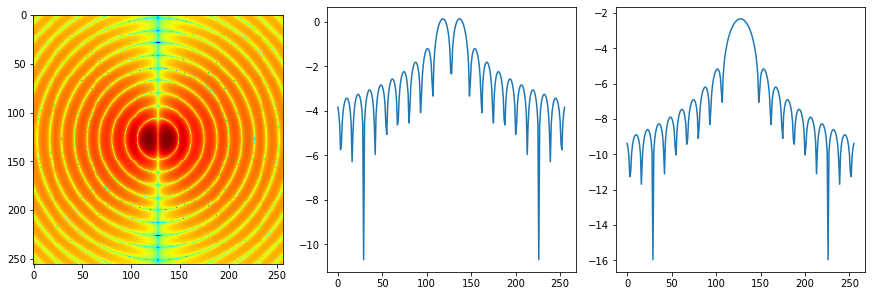

sin(θ)⋅besselj(2, 2⋅π⋅r)
────────────────────────
           r            

sum: 0.7508861404676261
max: 1.1287025666743613


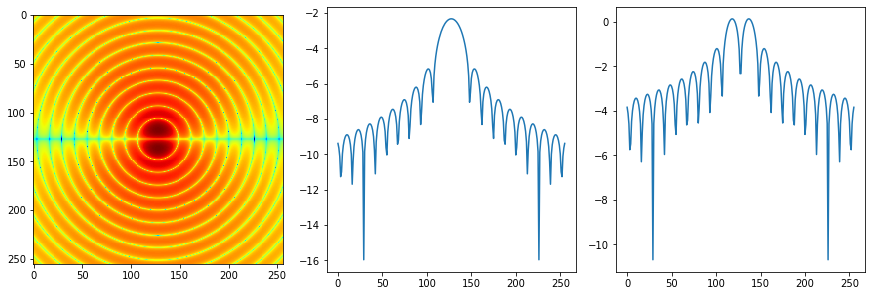

besselj(3, 2⋅π⋅r)
─────────────────
        r        

sum: 0.9823874537345993
max: 0.6959619280058139


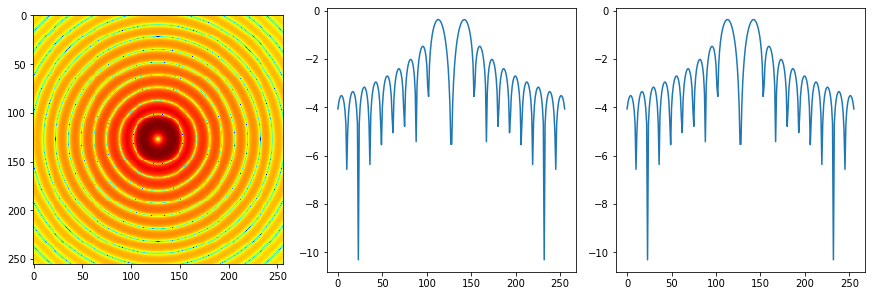

sin(2⋅θ)⋅besselj(3, 2⋅π⋅r)
──────────────────────────
            r             

sum: 0.4930485050207673
max: 0.6956844761613044


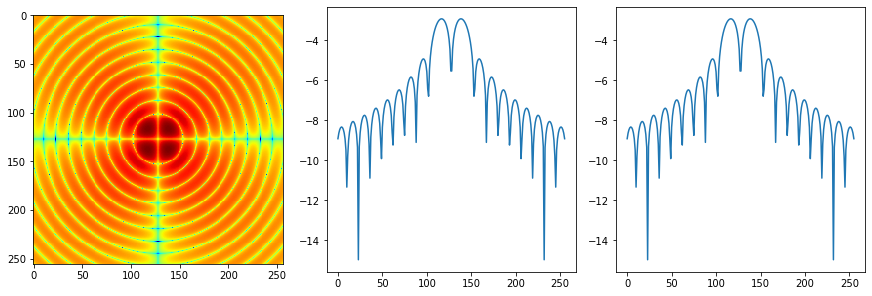

cos(2⋅θ)⋅besselj(3, 2⋅π⋅r)
──────────────────────────
            r             

sum: 0.4893389487138321
max: 0.6941588509463574


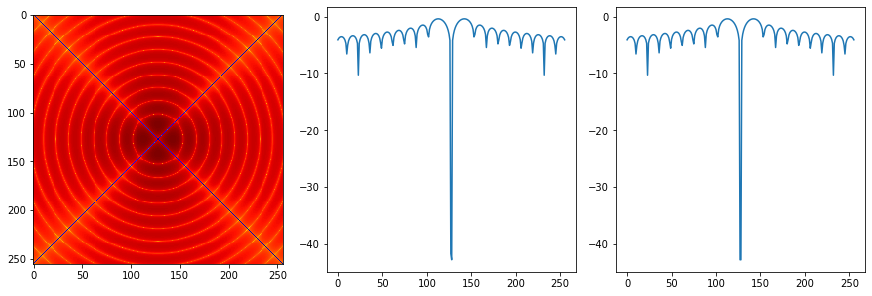

In [12]:
showFunctionZernikeDiffractedComplexAtFocus = partial(showFunction, ff=diffractedComplexZernikeAtFocus, isReal=False, doLog=True)
showFunctionZernikeDiffractedAtFocus = partial(showFunction, ff=diffractedZernikeAtFocus, isReal=True, doLog=True)
showFunctionZernikeDiffractedAtFocusDiff = partial(showRealComplexFunctionDiff, fr=diffractedZernikeAtFocus, fc=diffractedComplexZernikeAtFocus)
#showFunctionZernikeDiff = partial(showRealComplexFunctionDiff, fr=realZernike, fc=complexZernike)
showFunctionZernike = partial(showFunction, ff=realZernike,  isReal=True, doLog=False)
#modesIterator(showFunctionZernike, 6)
modesIterator(showFunctionZernikeDiffractedAtFocus, 6)
#modesIterator(showFunctionZernikeDiffractedAtFocusDiff, 6)

besselj(1, 2⋅π⋅r)
─────────────────
        r        

0.41730125424880493


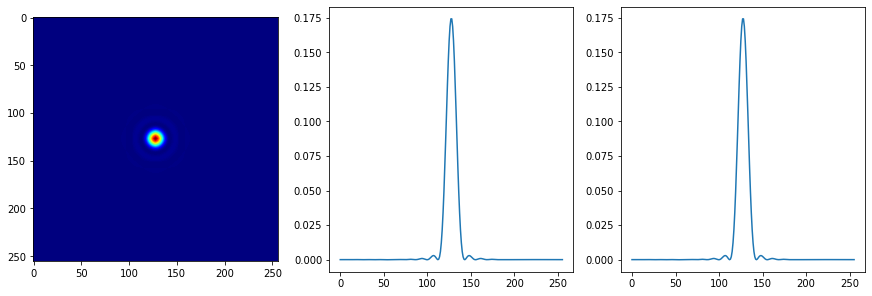

In [13]:
propMethodsCartesian = createPropagationFormulary(True, False, False)

xyCircle = propMethodsCartesian.getFormula('xyCircle')
xyLens = propMethodsCartesian.getFormula('xyLens')
rLens = propMethodsCartesian.getFormula('rLens')

mIt = Integrator('intensity', cp, cp.float64)
lll = 1e-6
aa =  0.001
FN = 100
dd = 2*aa
focal_dist = dd*FN
approximations1 = ["Near Fresnel", "Far Fresnel", "Fraunhofer"]
#distances = [focal_dist]
subdiv_points = 256

xyCircle =  subsParamsByName( xyCircle, {'a':aa} )
subsDictC = {'E_0': xyCircle, 'lambda': lll}

def computeModeDiffraction(nn, mm, method, sDict, pr, scaling=1):
    eeq = propMethodsCartesian.getFormula(method)
    rh =  subsParamsByName( eeq.rhs, {'a':aa} )
    sDict['E_0'] = sDict['E_0'] * subsParamsByName( realZernikeCartesian, {'n':nn, 'm':mm, 'a':aa} )
    rh = subsParamsByName( rh, sDict) 
    xxx, fplot = mIt.IntegralEval(eeq.lhs, rh, pr, [(subdiv_points, 'linear'), (subdiv_points, 'linear')])
    fplot *= scaling
    return fplot

def showDiffraction(nn, mm, method, sDict, pr, scaling=1):
    fplot1 = computeModeDiffraction(nn, mm, method, sDict, pr, scaling)
    Ur1 = samplePolarFunction(nn, mm, diffractedZernikeAtFocus, True)
    Ur1 = np.square(np.absolute(Ur1))
    fplot1 = fplot1-Ur1
#    fplot1 = Ur1
    print(np.max(np.sqrt(np.absolute(fplot1))))
    standardPsfPlot((fplot1))

subsDictC['z_1'] = focal_dist 
rrr = 1e-3
paramAndRange0 = [('x_1', -rrr, rrr, subdiv_points, 'linear'), ('y_1', -rrr, rrr, subdiv_points, 'linear')]

#subsDictC['E_0'] = xyCircle(x0, y0, aa)
#showDiffractionFra = partial(showDiffraction, method="Fraunhofer", sDict = subsDictC, pr = paramAndRange0, scaling= aa * aa * (np.pi ** 2) * 66.1)
#modesIterator(showDiffractionFra, 1)
subsDictC['E_0'] = xyCircle * subsParamsByName(xyLens, {'FN': FN,  'lambda': lll, 'a':aa})
showDiffractionFre = partial(showDiffraction, method="Far Fresnel", sDict = subsDictC, pr = paramAndRange0, scaling= 4*aa*aa*1000* np.pi ** 2 * 1.03)
modesIterator(showDiffractionFre, 1)

In [14]:
propMethodsPolar = createPropagationFormulary(False, False, False)
ez0_p = 1
subsDictP = {'E_0r': ez0_p, 'lambda': lll, 'a':aa}
ffp = propMethodsPolar
paramAndRange1 = [('r_1', 0.0, rrr, subdiv_points, 'linear'), ('theta_1', 0.0, 2*np.pi, subdiv_points, 'linear')]
m = approximations1[0]

def showFranhoferDiffractionP(nn, mm):
    sDict = subsDictP
    pr = paramAndRange1
    (lh, rh, eeq) = ffp.getFormula(m)
    sDict['z_1'] = distance 
    sDict['E_0r'] = realZernike(nn, mm).subs(rho, r0/a).subs(theta, theta0)
    rh = subsParamsByName(rh, sDict)
#    display(sDict['E_0r'])
    xxx, fplot1 = mIt.IntegralEval(lh, rh, pr, [(subdiv_points, 'sqrt'), (subdiv_points, 'linear')])
    fplot1 /= (2*np.pi)**2
    fplot1 = polar_to_cart(np.flip(fplot1.T, axis=0), 360.0/subdiv_points, 100e-6/subdiv_points, np.linspace(-100e-6, 100e-6, subdiv_points), np.linspace(-100e-6, 100e-6, subdiv_points))
    standardPsfPlot(np.log(fplot1))

In [15]:
display(diffractedZernike)
display(realZernike)
display(complexZernike)
display(realZernikeNormalized)
display(complexZernikeNormalized)

                                   nₘₐₓ                                       
                               ____________                                   
                               ╲                                              
                                ╲                         n   │m│             
                                 ╲                        ─ - ───             
                                  ╲                       2    2              
                                   ╲                      ________            
                                    ╲                     ╲                   
                                     ╲                     ╲           n   │m│
                                      ╲                     ╲          ─ - ───
                                       ╲                     ╲         2    2 
                                        ╲                     ╲    (-1)       
  ⎛⎧-sin(m⋅θ)  for m < 0⎞  ⅈ⋅f           ╲          

    n - │m│  │m│ ⎛⎧-sin(m⋅θ)  for m < 0⎞       ⎛n   │m│             2    ⎞
(-1)       ⋅ρ   ⋅⎜⎨                    ⎟⋅jacobi⎜─ - ───, 0, │m│, 2⋅ρ  - 1⎟
                 ⎝⎩cos(m⋅θ)   otherwise⎠       ⎝2    2                   ⎠

    n - │m│     │m│  ⅈ⋅m⋅θ       ⎛n   │m│             2    ⎞
(-1)       ⋅√2⋅ρ   ⋅ℯ     ⋅jacobi⎜─ - ───, 0, │m│, 2⋅ρ  - 1⎟
                                 ⎝2    2                   ⎠
────────────────────────────────────────────────────────────
                             2                              

    n - │m│  │m│   _________ ⎛⎧-sin(m⋅θ)  for m < 0⎞       ⎛n   │m│           
(-1)       ⋅ρ   ⋅╲╱ 2⋅n + 2 ⋅⎜⎨                    ⎟⋅jacobi⎜─ - ───, 0, │m│, 2
                             ⎝⎩cos(m⋅θ)   otherwise⎠       ⎝2    2            

  2    ⎞
⋅ρ  - 1⎟
       ⎠

    n - │m│  │m│   _______  ⅈ⋅m⋅θ       ⎛n   │m│             2    ⎞
(-1)       ⋅ρ   ⋅╲╱ n + 1 ⋅ℯ     ⋅jacobi⎜─ - ───, 0, │m│, 2⋅ρ  - 1⎟
                                        ⎝2    2                   ⎠

In [16]:
nm=3
ln = kn = 2048*4

coeffs = np.asarray([ 1.1, 0.9, 0.3, 0.77, 0.78, 0.76, 0, 0, 0, 0])
one_f = zernikeSynthesysReal(coeffs)

max_noll = int((nm+1)*(nm+2)/2)

alpha_coeff = np.zeros(max_noll)
r_integrals = np.zeros((max_noll, ln))
t_integrals = np.zeros((max_noll, ln))

r_samples = np.linspace(0.0, 1.0, ln+1)
#r_samples = np.sqrt(r_samples)
r_samples -= (1.0/ln)/2.0
r_samples = np.cos(np.pi/2.0*(1.0 - r_samples))

t_samples = np.linspace(0.0, 2.0*np.pi, ln+1)
t_samples -= (2.0*np.pi/ln)/2.0

print("max_noll:", max_noll)
for ni in range(int(max_noll)):
    nn, mm = noll_to_zern(ni+1)
    fr = radialFunc(n,m).subs({n:nn, m:mm}) * rho
    ft = tangetialFunc(n,m).subs({n:nn, m:mm})
    ifr = sp.Integral(fr, rho ).doit()
    ift = sp.Integral(ft, theta ).doit()
    ifr_l = sp.lambdify(rho, ifr)
    ift_l = sp.lambdify(theta, ift)
    r_integrals[ni, :] = - ifr_l(r_samples[:-1]) + ifr_l(r_samples[1:])
    t_integrals[ni, :] = - ift_l(t_samples[:-1]) + ift_l(t_samples[1:])


one_f_l = sp.lambdify((rho,theta), one_f, "scipy")
rm, tm = np.meshgrid(r_samples, t_samples, sparse=True, copy=False)
one_f_l_eval = one_f_l(rm, tm)

for ni in range(int(max_noll)):
    ss = 0.0
    ri = r_integrals[ni, :]
    ti = t_integrals[ni, :]
    rim, tim = np.meshgrid(ri,ti, sparse=True, copy=False)
    ss = np.sum(one_f_l_eval[:-1,:-1]*rim*tim)       
    nn, mm = noll_to_zern(ni+1)
    ev = emValue(mm)*np.pi/np.sqrt(2*nn+2)
    alpha_coeff[ni] =   ss / ev 
    
print(np.max((alpha_coeff-coeffs)))
print(alpha_coeff)

NameError: name 'zernikeSynthesysReal' is not defined

In [17]:
nm=3
max_noll = (nm+1)*(nm+2)/2
for ni in range(int(max_noll)):
    for nj in range(int(max_noll)):
        nn, mm = noll_to_zern(ni+1)
        z_ni = complexZernike(n,m).subs({n:nn, m:mm} )
        nn, mm = noll_to_zern(nj+1)
        z_nj = complexZernike(n,m).subs({n:nn, m:mm} )
        em=1
        if ni!=nj:
            em=0
        print( ni, nj, circleDotProduct(z_ni, z_nj), em /(nn+1) )

NameError: name 'n' is not defined

In [ ]:
nm=3
max_noll = (nm+1)*(nm+2)/2
for ni in range(int(max_noll)):
    for nj in range(int(max_noll)):
        nn, mm = noll_to_zern(ni+1)
        z_ni = realZernike(n,m).subs({n:nn, m:mm} )
        nn, mm = noll_to_zern(nj+1)
        z_nj = realZernike(n,m).subs({n:nn, m:mm} )
        em = emValue(mm)
        if ni!=nj:
            em=0
        print( ni, nj, circleDotProduct(z_ni, z_nj), em /(2*nn+2) )

In [ ]:
one_f = zernikeSynthesysReal([ 1.1, 0.9+0.1j, 0.3, 0.77, 0.78, 0.76+1j, 0,0])
display(one_f)
beta_vector = zernikeAnalysysReal(one_f, 10)



In [ ]:
one_f = zernikeSynthesysComplex([ 1.1, 0.9+0.1j, 0.3, 0.77, 0.78, 0.76+1j, 0,0])
display(one_f)
beta_vector = zernikeAnalysysComplex(one_f, 10)


In [ ]:
zf = Formulary()
zzz = sp.symbols('Z_44')
az = realZernikeNormalized(4,4)
zf.addFormula('Z44', (zzz, az, sp.Eq(zzz, az) ) )

rr, th = getZernikeDomain(256)

zf.plotFormula('Z44', {}, ['rho', 'theta'], [rr, th], 'numpy')



In [ ]:
NN = 64
zf = createZernikeFormulary(NN)
grid_size=1024
rr, th = getZernikeDomain(grid_size)

xx = np.zeros(NN-1)
varr = np.zeros(NN-1)
marr = np.zeros(NN)
for i in range(NN-1):
    xx[i] = i+2
    idx = noll_to_zern(i+2)
    zname = 'Z' + str(idx[0]) + str(idx[1])
    _, _, z1 = zf.evaluateFormula(zname, {}, ['rho', 'theta'], [rr, th], 'scipy')    
    nn = np.count_nonzero(~np.isnan(z1))
    z1[np.isnan(z1)] = 0.0
    marr[i] = np.sum(z1)/nn
    varr[i] = np.sum(np.abs(z1-marr[i])**2)/nn
    
plt.xscale('log')
plt.yscale('log')
plt.plot(xx, varr)
plt.show()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interactive, fixed
from ipywidgets import BoundedIntText, Output, Label

from mpl_toolkits import mplot3d

from IPython.display import display_latex, display

out = Output(layout={'border': '1px solid black'})

def showOneZernike(i, sampling_points, fig, ax):
    idx = noll_to_zern(i)
    zerninke_mode_expression = oneZernikeNormalized(idx[0], idx[1]).simplify()
    out.clear_output()
    with out:
        display(zerninke_mode_expression)        
    X1, Y1, Z1 = evaluateZernike(zerninke_mode_expression, sampling_points)
    mm = np.max(np.abs(Z1))
    ax.clear()
    surf = ax.plot_surface(X1, Y1, Z1, rstride=2, cstride=2, cmap='jet', linewidth=0.05, antialiased=True, edgecolor='black')
    ax.set_zlim(-mm*1.05, mm*1.05)
    # fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_title('Surface plot')
           
caption01 = widgets.Label(value='Radial degree (n) :')
caption02 = widgets.Label(value='Azimuthal degree (m) : ')
caption1 = widgets.Label(value='')
caption2 = widgets.Label(value='')

def handle_index_change(change):
    caption1.value = str(noll_to_zern(change.new)[0])
    caption2.value = str(noll_to_zern(change.new)[1])

a = BoundedIntText( value=2, min=2, max=2000, step=1,  description='Noll index:',  disabled=False )
b = BoundedIntText( value=256, min=16, max=2048, step=1,  description='x,y sampling:',  disabled=False )

a.observe(handle_index_change, names='value')

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(projection='3d')
            
def f(m, p):
    showOneZernike(m, p, fig, ax)

display( widgets.VBox( [ out, caption01, caption1, caption02, caption2, interactive(f, m=a, p=b)  ] ) )
#output = interactive_plot.children[-1]
fig.canvas.layout.width = '500px'

In [ ]:
sampling_points=1000

zs = oneZernikeNormalized(3, 3).simplify()
display(zs)

zlc = sp.lambdify((rho, theta), zs, modules= [cplib] )   
zln = sp.lambdify((rho, theta), zs, modules= 'numpy' )   
#print(inspect.getsource(zl))

r1 = np.power(np.linspace(0.0, 1.0, sampling_points), 1.0/2.0)
theta1 = np.linspace(0, 2*np.pi, sampling_points)
r1, theta1 = np.meshgrid(r1, theta1)
X1 = r1 * np.sin(theta1)
Y1 = r1 * np.cos(theta1)

In [ ]:
%%timeit
z1c =  zlc(cp.asarray(r1), cp.asarray(theta1))
Z1c = cp.asnumpy(z1c)
#plt.imshow(Z1c)

In [ ]:
#%%timeit
z1n =  zln(r1, theta1)
Z1n = z1n
plt.imshow(Z1n)